In [1]:
!pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2

In [3]:
splitfolders.ratio("/kaggle/input/bullous-disease/Bullous",
                   output="/kaggle/working/dataset_split",
                   ratio=(0.7, 0.15, 0.15))

Copying files: 543 files [00:00, 755.13 files/s]


In [4]:
data_dir_train = pathlib.Path( '/kaggle/working/dataset_split/train')
img_height,  img_width  = 299, 299

In [5]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123,
                                        image_size=(img_height, img_width))

Found 376 files belonging to 11 classes.


In [6]:
class_names = train_ds.class_names
class_names

['Benign Familial Chronic Pemphigus',
 'Bullous pemphigoid',
 'Dariers disease',
 'Dermatitis herpetiformis',
 'Diabetic bullae',
 'Epidermolysis bullosa',
 'Grovers disease',
 'Herpes gestationis',
 'Localized pemphigoid',
 'Pemphigus ',
 'Pemphigus foliaceous']

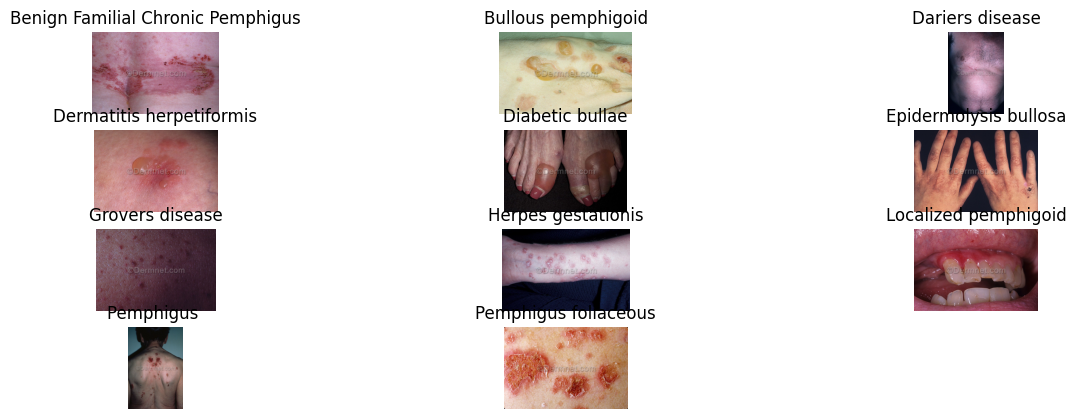

In [7]:
### Visualizing the training data
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(8, 3, i+1)

    # Correct indentation for the following lines
    data_path = os.path.join(str(data_dir_train), class_)
    file_paths = glob.glob(os.path.join(data_path, '*.*'))
    random_img_path = random.choice(file_paths)
    img = PIL.Image.open(random_img_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")

plt.show()

In [8]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.*')))

class_size

{'Benign Familial Chronic Pemphigus': 21,
 'Bullous pemphigoid': 73,
 'Dariers disease': 44,
 'Dermatitis herpetiformis': 65,
 'Diabetic bullae': 19,
 'Epidermolysis bullosa': 41,
 'Grovers disease': 41,
 'Herpes gestationis': 10,
 'Localized pemphigoid': 7,
 'Pemphigus ': 37,
 'Pemphigus foliaceous': 18}

In [9]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
Benign Familial Chronic Pemphigus,21
Bullous pemphigoid,73
Dariers disease,44
Dermatitis herpetiformis,65
Diabetic bullae,19
Epidermolysis bullosa,41
Grovers disease,41
Herpes gestationis,10
Localized pemphigoid,7
Pemphigus,37


In [10]:
batch_size = 32
img_size = 299

In [11]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=15,                  # slightly more aggressive rotation
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,            # NEW: vertical shift
                                    shear_range=0.15,                  # NEW: shear transformation
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=[0.3, 0.9],
                                    channel_shift_range=30.0,          # NEW: random color/intensity shift
                                    fill_mode='nearest'                # ensures empty areas after transformation are filled well
                                  )


test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
training_set = train_datagen.flow_from_directory('/kaggle/working/dataset_split/train',
                                               target_size=(299,299),
                                                 batch_size=32)

test_set = test_datagen.flow_from_directory('/kaggle/working/dataset_split/val',
                                            target_size=(299,299),
                                            batch_size=32,
                                            shuffle=False)

Found 376 images belonging to 11 classes.
Found 75 images belonging to 11 classes.


In [12]:
def Xception_finetune(weights_path):
    
    base_model = Xception(weights=None, include_top=False, input_shape=(299, 299, 3))
    
    base_model.load_weights(weights_path)

    base_model.trainable = False

    x = base_model.output
    

    # Add new classifier head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    new_output = layers.Dense(11 , activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=new_output)
    # Use Categorical focal loss 
    focal_loss_func = CategoricalFocalCrossentropy(gamma=2.0)
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=focal_loss_func,
        metrics=['accuracy']
    )

    return model, base_model

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=3,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [14]:
filepath = '/kaggle/working/checkpoint/acne_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [15]:
os.makedirs('/kaggle/working/Models/categories/', exist_ok=True)

In [16]:
def train():
    time_start = time.time()

    # Initialize the model
    model, base_model = Xception_finetune(
        weights_path='/kaggle/input/weights/tensorflow2/default/1/category.weights.h5'
    )
    model.summary()

    # Phase 1: Train only the new top layers (all base layers frozen)
    print("\nPhase 1: Training top layers only...")

    history_all = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    history = model.fit(
        training_set,
        epochs=5,
        validation_data=test_set,
        callbacks=[early_stopping, learning_rate_reduction, reduce_lr, checkpoint]
    )

    for key in history.history:
        if key not in history_all:
            history_all[key] = []
        history_all[key] += history.history[key]

    # Prepare for progressive unfreezing
    total_layers = len(model.layers)
    unfrozen = 5
    max_unfreeze = 60
    phase = 2

    while unfrozen < total_layers and unfrozen <= max_unfreeze:
        print(f"\nPhase {phase}: Unfreezing last {unfrozen} layers...")

        for layer in model.layers[-unfrozen:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

        history = model.fit(
            training_set,
            epochs=5,
            validation_data=test_set,
            callbacks=[early_stopping, learning_rate_reduction, checkpoint]
        )

        for key in history.history:
            if key not in history_all:
                history_all[key] = []
            history_all[key] += history.history[key]

        unfrozen += 5
        phase += 1

    model.save_weights('/kaggle/working/Models/categories/Bullous.weights.h5')
    model.save('/kaggle/working/Models/categories/Bullous.h5')

    print('Model saved.')
    print('Training Time:', time.time() - time_start)
    print('\n')

    return history_all

In [17]:
from tensorflow.keras.models import load_model

def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod = keras.models.load_model('/kaggle/working/Models/categories/Bullous.h5')
    mod.evaluate(test_set)

    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1)


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [18]:
input_path = '/kaggle/working/dataset_split/val'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(299, 299))

Found 75 files belonging to 11 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,133,363 (80.62 MB)

 Trainable params: 267,787 (1.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)


Phase 1: Training top layers only...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.1174 - loss: 3.2015 - val_accuracy: 0.2667 - val_loss: 2.9309 - learning_rate: 3.0000e-04
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 711ms/step - accuracy: 0.2738 - loss: 2.9375 - val_accuracy: 0.3200 - val_loss: 2.8279 - learning_rate: 3.0000e-04
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 710ms/step - accuracy: 0.3277 - loss: 2.7771 - val_accuracy: 0.3333 - val_loss: 2.7415 - learning_rate: 3.0000e-04
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 714ms/step - accuracy: 0.3539 - loss: 2.6482 - val_accuracy: 0.4400 - val_loss: 2.6480 - learning_rate: 3.0000e-04
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 638ms/step - accuracy: 0.3703 - loss: 2.5485 - val_accuracy: 0.4400 - val_loss: 2.5519 - learning_rate: 3.0000e-04

Phase 2: Unfreezing last 5 layers...
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 852ms/step - accuracy: 0.4004 - loss: 2.4789 - val_accuracy: 0.4800 - val_loss: 2.4657 - learning_rate: 3.0000e-04
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 14

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'history' is not defined

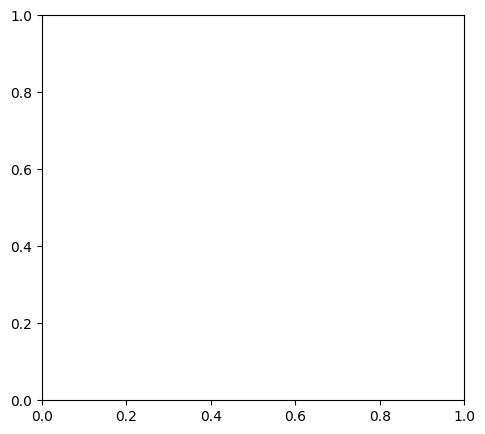

In [19]:
def plot_training_history(history_all):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    key = train_data.class_names
    train_history = train()
    prob, predIdxs, model = test()

    # Plot training history
    plot_training_history(train_history)


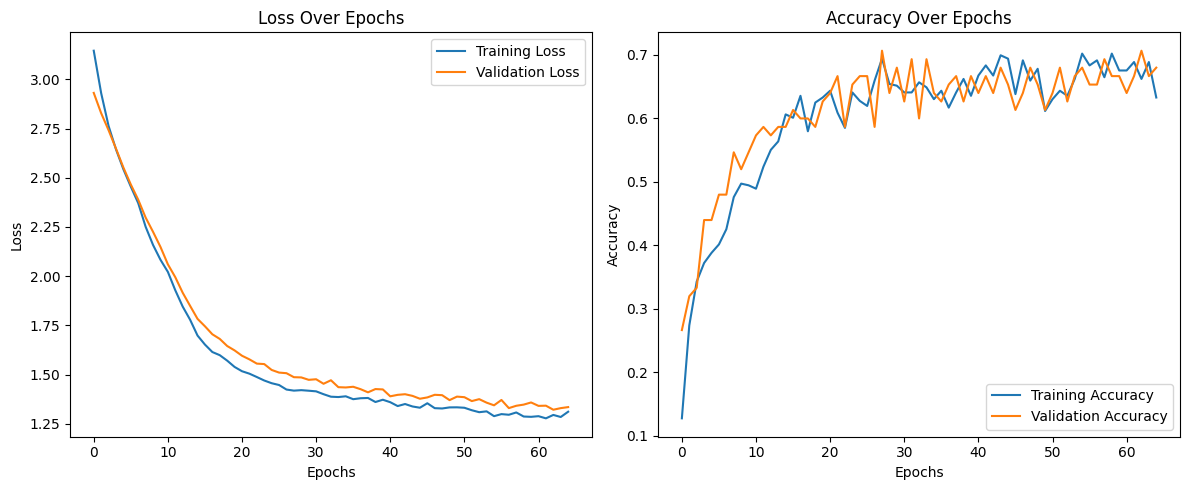

In [28]:
def plot_training_history(history_all):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_all['loss'], label='Training Loss')
    plt.plot(history_all['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_all['accuracy'], label='Training Accuracy')
    plt.plot(history_all['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(train_history)


In [20]:
# Define test data generator for final testing
final_test_datagen = ImageDataGenerator(rescale=1./255)

# Load final test set
final_test_set = final_test_datagen.flow_from_directory('/kaggle/working/dataset_split/test/',
                                                        target_size=(299, 299),
                                                        batch_size=32,
                                                        shuffle=False)  

# Load the model
mod = keras.models.load_model('/kaggle/working/Models/categories/Bullous.h5')
 
# Evaluate the model on the final test set
final_test_loss, final_test_accuracy = mod.evaluate(final_test_set)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predicting and classification report
prob = model.predict(final_test_set)
predIdxs = np.argmax(prob, axis=1)

# Get class names from class indices
class_names = list(final_test_set.class_indices.keys())

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(final_test_set.classes, predIdxs, target_names=class_names))

Found 92 images belonging to 11 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step - accuracy: 0.5678 - loss: 1.3599 
Final Test Loss: 1.353023886680603
Final Test Accuracy: 0.5652173757553101
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step
                                   precision    recall  f1-score   support

Benign Familial Chronic Pemphigus       0.50      0.40      0.44         5
               Bullous pemphigoid       0.65      0.65      0.65        17
                  Dariers disease       0.45      0.45      0.45        11
         Dermatitis herpetiformis       0.55      0.73      0.63        15
                  Diabetic bullae       0.44      0.80      0.57         5
            Epidermolysis bullosa       0.71      0.50      0.59        10
                  Grovers disease       0.44      0.40      0.42        10
               Herpes gestationis       0.00      0.00      0.00         3
             Localized pemphigoid       1.00      0.50      0.67         2
                       Pemphigus        0.58      0.78      0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


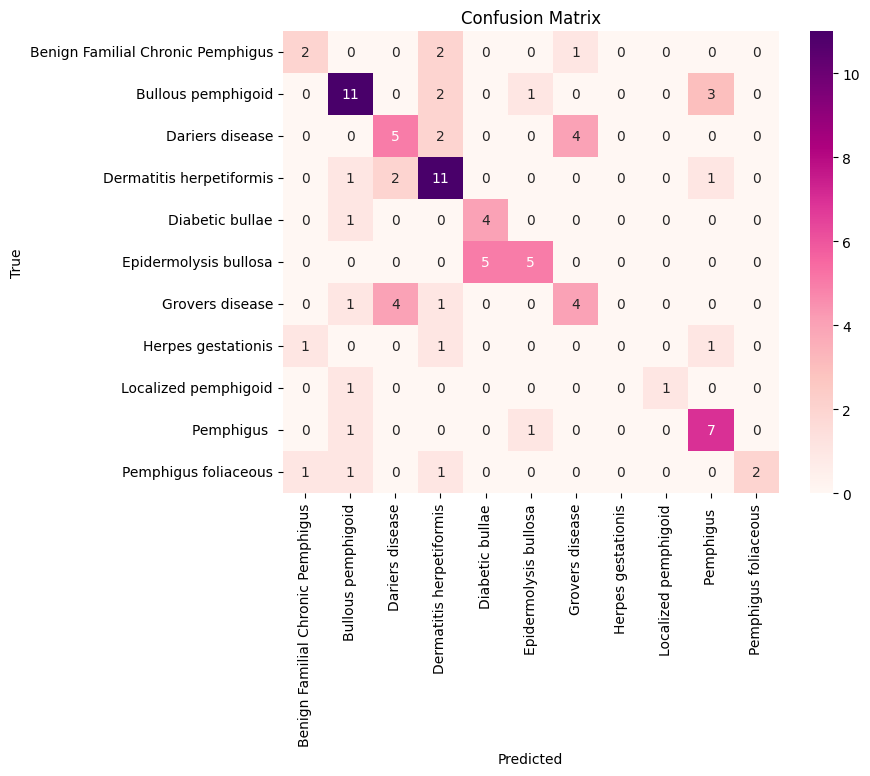

In [22]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(final_test_set.classes, predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()